<a href="https://colab.research.google.com/github/antonysama/Projects_w._time_series/blob/master/Fisheries_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install feature-engine

In [ ]:
%%capture
!pip install CatBoost

In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# other regressors: https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
import scipy.stats as stats
import feature_engine.transformation as vt
from feature_engine.outliers import Winsorizer

pd.pandas.set_option('display.max_columns', None)

# for cross validation and grid search
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    LeavePOut,
    StratifiedKFold,
    GridSearchCV,
    train_test_split,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# below two are for correltation
from sklearn.model_selection import train_test_split, cross_validate

from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection

# to determine the p-values with anova
from sklearn.feature_selection import f_classif, f_regression

# to select features
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
# load dataset
fields = ['SPECIES','STORAGE_TYPE','GEAR_NME','MGMT_AREA','LICENCE_AREA','DATE','Vessel ID Number','GEAR_CDE','SUB_AREA'
,'SA_ORIGIN','Nominal_Value','KG_PIECE','Nominal_PRICE_PIECE']
data=pd.read_csv('drive/MyDrive/q2.csv', error_bad_lines=False,usecols=fields)
# data=pd.read_csv('q2.csv', error_bad_lines=False)

print(data.shape)
data.head()

(566739, 13)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SPECIES,STORAGE_TYPE,GEAR_NME,MGMT_AREA,LICENCE_AREA,DATE,Vessel ID Number,GEAR_CDE,SUB_AREA,SA_ORIGIN,KG_PIECE,Nominal_PRICE_PIECE,Nominal_Value
0,CHUM SALMON,UNKNOWN,SEINE,13,SALMON AREA B,10/17/2016,4856,20,28,LOG_BOOK,4.391591,8.540229,227298.1995
1,CHUM SALMON,UNKNOWN,SEINE,14,SALMON AREA B,11/6/2011,3980,20,4,LOG_BOOK,4.595482,8.611520,215287.9969
2,SOCKEYE SALMON,UNKNOWN,SEINE,29,SALMON AREA B,9/12/2018,3952,20,3,LOG_BOOK,2.685285,16.368153,212785.9900
3,SOCKEYE SALMON,UNKNOWN,SEINE,29,SALMON AREA B,9/14/2018,3820,20,4,LOG_BOOK,2.781680,16.406279,205078.4896
4,SOCKEYE SALMON,UNKNOWN,SEINE,29,SALMON AREA B,9/12/2018,5448,20,3,LOG_BOOK,2.781614,16.955322,178030.8788


In [ ]:
# Disaggregate date 
data[["month", "day", "year"]] = data["DATE"].str.split("/", expand = True)
data.drop(['DATE'], axis=1 , inplace=True) # nex time, don't drop 'day'
data.head(2)


,SPECIES,STORAGE_TYPE,GEAR_NME,MGMT_AREA,LICENCE_AREA,Vessel ID Number,GEAR_CDE,SUB_AREA,SA_ORIGIN,KG_PIECE,Nominal_PRICE_PIECE,Nominal_Value,month,day,year
0,CHUM SALMON,UNKNOWN,SEINE,13,SALMON AREA B,4856,20,28,LOG_BOOK,4.391591,8.540229,227298.1995,10,17,2016
1,CHUM SALMON,UNKNOWN,SEINE,14,SALMON AREA B,3980,20,4,LOG_BOOK,4.595482,8.611520,215287.9969,11,6,2011


In [ ]:
data.isnull().mean()

SPECIES                0.0
STORAGE_TYPE           0.0
GEAR_NME               0.0
MGMT_AREA              0.0
LICENCE_AREA           0.0
Vessel ID Number       0.0
GEAR_CDE               0.0
SUB_AREA               0.0
SA_ORIGIN              0.0
KG_PIECE               0.0
Nominal_PRICE_PIECE    0.0
Nominal_Value          0.0
month                  0.0
day                    0.0
year                   0.0
dtype: float64

In [ ]:
# Inspected the type of variables in pandas, and changed as appropriate
for col in ['MGMT_AREA','GEAR_CDE','SUB_AREA']:
    data[col] = data[col].astype(object)
for col in ['month','day','year']:
    data[col] = data[col].astype(int)
data.dtypes

SPECIES                 object
STORAGE_TYPE            object
GEAR_NME                object
MGMT_AREA               object
LICENCE_AREA            object
Vessel ID Number        object
GEAR_CDE                object
SUB_AREA                object
SA_ORIGIN               object
KG_PIECE               float64
Nominal_PRICE_PIECE    float64
Nominal_Value          float64
month                    int64
day                      int64
year                     int64
dtype: object

In [ ]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 9 categorical variables


In [ ]:
# make a list of the numerical variables first
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain temporal information
# temporal_vars = [var for var in categorical if 'month' in var or 'year' in var or 'day' in var]

numerical #, temporal_vars

['KG_PIECE', 'Nominal_PRICE_PIECE', 'Nominal_Value', 'month', 'day', 'year']

Text(0, 0.5, 'Nominal value')

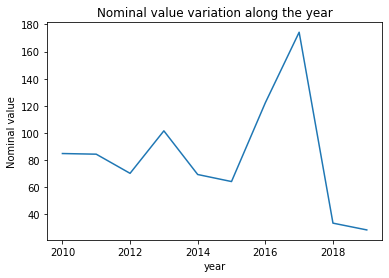

In [ ]:
# plot nominal value per month or year

data.groupby('year')['Nominal_Value'].median().plot()
plt.title('Nominal value variation along the year')
plt.ylabel('Nominal value')

In [ ]:
# tabulate nominal value per species or other catefory
data.groupby('year')['Nominal_Value'].median().reset_index()
# data.groupby('year')['Nominal_Value'].median().sort_values(ascending=False).reset_index() # to order by nominal value

,year,Nominal_Value
0,2010,84.785689
1,2011,84.307003
2,2012,70.178571
3,2013,101.522777
4,2014,69.314292
5,2015,64.121179
6,2016,122.234509
7,2017,174.259378
8,2018,33.437152
9,2019,28.439915


In [ ]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 35:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

month  values:  [10 11  9  8  6  7  5  4  2  3  1 12]
day  values:  [17  6 12 14 22  9 11 26 13 20 18 16  2 15 10 27 24 28 23 31 30 29  3  1
  5  8 25  4 19 21  7]
year  values:  [2016 2011 2018 2010 2014 2017 2015 2013 2012 2019]

There are 3 discrete variables


In [ ]:
# find continuous variables
# skip the target and correlated vars
continuous = [var for var in numerical if var not in discrete  
              and var not in ['Nominal_Value']]

print('There are {}  continuous variables'.format(len(continuous)))

There are 2  continuous variables


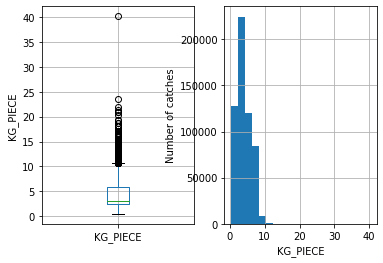

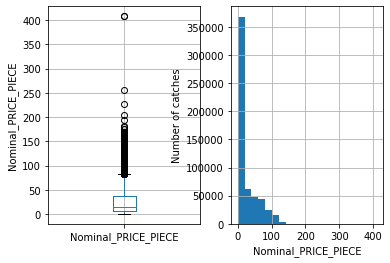

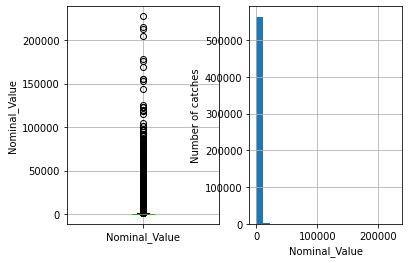

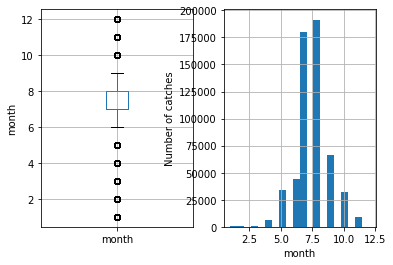

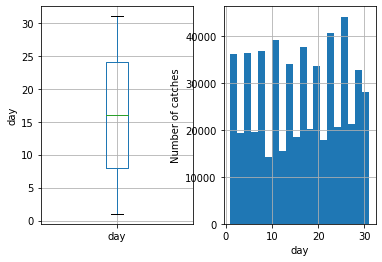

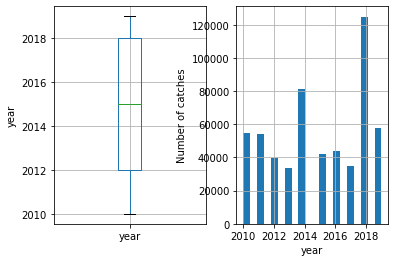

In [ ]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Number of catches')
    fig.set_xlabel(var)

    plt.show()

Text(0, 0.5, 'Number of different categories')

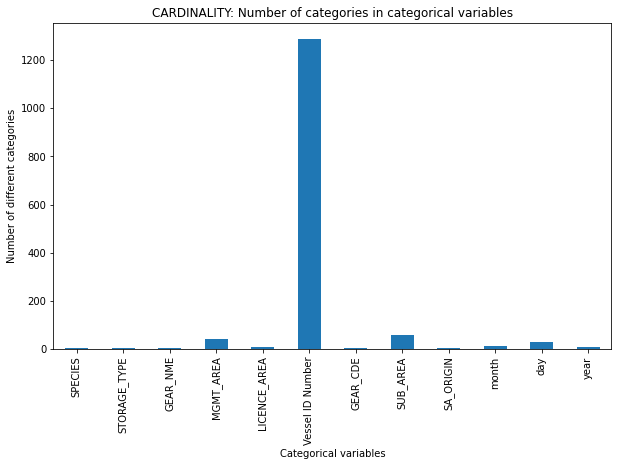

In [ ]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [ ]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop('Nominal_Value', axis=1),
                                                    data['Nominal_Value'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((510065, 14), (56674, 14))

In [ ]:
fisheries_pipe = Pipeline([
    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelEncoder(
        tol=0.05, n_categories=6, variables=categorical)), 
    
    ('categorical_enc', ce.OrdinalEncoder(
        encoding_method='ordered', variables=categorical)), # can try 'arbitrary' or 'ordered'

    #  # transform - SECTION 7   # didn't increase R2
     ('lt', vt.LogTransformer(variables = continuous+discrete)), # a.k.a 'continuous

    # discretisation + encoding - section 8
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=continuous+discrete)),
      
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=continuous+discrete)),

    # # outlier capping - sectionn 9 #didn't increase r2
    ('windsoriser', Winsorizer(
        capping_method='gaussian', tail='both', fold=3, variables=continuous+discrete)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),
    
    # regression
    # ('classifier', RandomForestRegressor()) # best are LGBMRegressor, RandomForestRegressor
    ('classifier', RandomForestRegressor(random_state=10, n_estimators=700, max_features='sqrt'))  
])

In [ ]:
# now we create the hyperparameter space that we want to sample
# to perform Grid search, we need to specifically provide the hyperparameter
param_grid = { 
    'rare_label_enc__tol': [0.1, 0.5],
    'classifier__n_estimators': [10, 300, 800],#need some others
    'classifier__max_depth': [5, 10,30, 50, None],
    'classifier__min_samples_split': [2,4,8],
    'classifier__max_depth':[3,6],
}

# # K-Fold Cross-Validation
# kf = KFold(n_splits=3, shuffle=True, random_state=10)

# search
grid_search =  GridSearchCV(
    fisheries_pipe,
    param_grid,
    scoring='r2',
    cv=5, # k-fold
    refit=True, # refits best model to entire dataset
)

In [ ]:
# let's fit the pipeline - two pipeline options: fisheries or grid_search

# let's get the predictions
fisheries_pipe.fit(X_train, y_train) 
X_train_preds = fisheries_pipe.predict(X_train) # 
X_test_preds = fisheries_pipe.predict(X_test) # 

# grid_search.fit(X_train, y_train)
# X_train_preds = grid_search.predict(X_train)
# X_test_preds = grid_search.predict(X_test)

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable SPECIES is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable STORAGE_TYPE is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_NME is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_CDE is less tha

In [ ]:
# check model performance:
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train r2: 0.6329867110165165

test r2: 0.5732090428424754


Text(0, 0.5, 'Predicted Price')

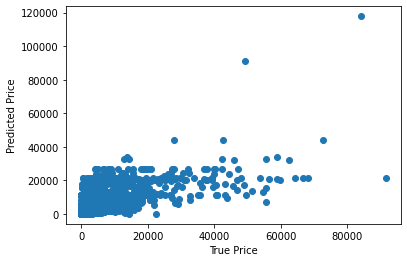

In [ ]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

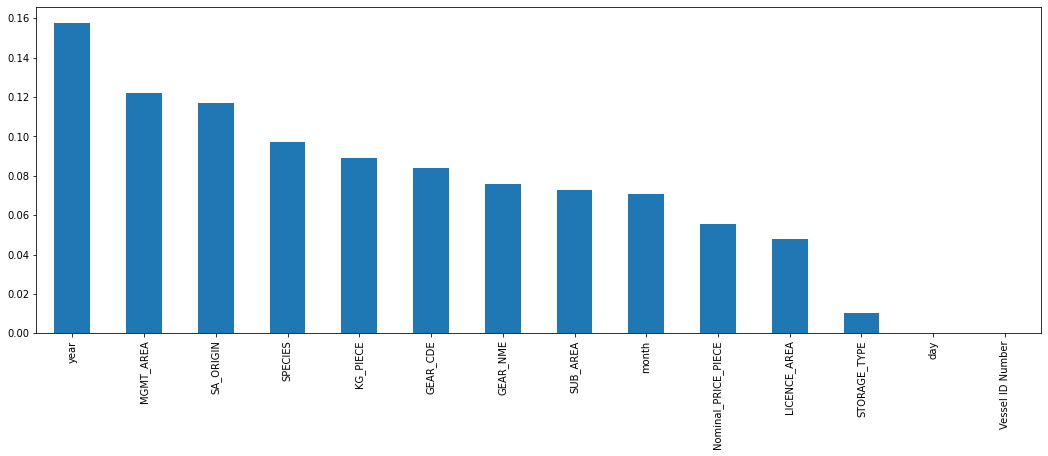

In [ ]:
# let's explore the importance of the features

importance = pd.Series(np.abs(fisheries_pipe.named_steps['classifier'].feature_importances_))
importance.index = list(X_train.columns) 
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))

In [ ]:
print(X_test_preds)

[  82.03148752 4142.27803419  387.8465399  ...   25.7546431    72.56969631
  923.37429645]


save model to predct new data https://scikit-learn.org/stable/modules/model_persistence.html https://stackoverflow.com/questions/47416982/load-and-predict-new-data-sklearn/47417363